<h1>Importing Libraries</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
import random
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import os

<h1>Importing Train Test Files</h1>

In [3]:
train_data = pickle.load(open('/content/drive/My Drive/Instacart Analysis/final_data_trainn.pkl','rb'))
test_data = pickle.load(open('/content/drive/My Drive/Instacart Analysis/final_data_test.pkl','rb'))

<h1>Data & Result Split</h1>

In [4]:
X = train_data.drop('reordered', axis=1)
Y = train_data['reordered'].values

In [5]:
# Replacing the infinite values with NaN first and then with the mean value.

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

<h1>Preprocessing Data</h1>

In [6]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
def normalize(df):
    #This function normalizes data by applying min max scaler

    result1 = df.copy()
    for feature_name in df.columns:
        array_values = np.asarray(df[feature_name].values)
        array = array_values.reshape(-1,1)
        minmax.fit(array)
        scaled = minmax.transform(array)
        result1[feature_name] = scaled
    return result1

processed_x = normalize(X)

<h1>Train Test Split</h1>

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(processed_x, Y, stratify = Y, test_size=0.2, random_state=14)

print("Train size", X_train.shape, Y_train.shape)
print("Test size", X_test.shape, Y_test.shape)

Train size (6779728, 25) (6779728,)
Test size (1694933, 25) (1694933,)


<h1>Building Models</h1>

#Note

1. As there are many models making submission with each of them doesn't make sense and is time consuming.

2. So I will look into Validation F1-Score and will pick the model with best Validation F1-Score.

3. Will compare validation F1-Score of each model.

4. Then will predict the real test data through that model and will create submission file

<h2> 1. Logistic Regression </h2>

<h3> Tuning Logistic Regression</h3>

In [ ]:
C = [0.001,1,100]
for i in C:
  lr_temp = LogisticRegression(C=i)
  lr_temp.fit(X_train, Y_train)
  train_predict = (lr_temp.predict_proba(X_train)[:,1]>=0.21).astype('int')
  test_predict = (lr_temp.predict_proba(X_test)[:,1]>=0.21).astype('int')

  f1_train = f1_score(train_predict, Y_train)
  f1_test = f1_score(test_predict, Y_test)

  print("Train F1 Score At C = {0} is {1}".format(i, f1_train))
  print("Test F1 Score At C = {0} is {1}".format(i, f1_test))


Train F1 Score At C = 0.001 is 0.41359469062720733
Test F1 Score At C = 0.001 is 0.4143218690280113
Train F1 Score At C = 1 is 0.41443100984586545
Test F1 Score At C = 1 is 0.4153962307155373
Train F1 Score At C = 100 is 0.41445507389710123
Test F1 Score At C = 100 is 0.4153770740354418


<h3>Logistic Regression With Best Parameter</h3>

In [ ]:
lr = LogisticRegression(C=1)
lr.fit(X_train, Y_train)

train_pred = (lr.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
test_pred = (lr.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

f1_train = f1_score(train_pred, Y_train)
f1_test = f1_score(test_pred, Y_test)

print("Train F1 Score:", f1_train)
print("Validation F1 Score:", f1_test)

Train F1 Score: 0.41443100984586545
Validation F1 Score: 0.4153962307155373


<h2> 2. Decision Tree </h2>

<h3>Tuning Decision Tree</h3>

In [ ]:
depth = [3, 5, 7, 10]
splits = [5,20,50,100,300,500]

for i in depth:
    for j in splits:
        dtree = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
        dtree.fit(X_train,Y_train)

        train_pred = (dtree.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
        test_pred = (dtree.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

        f1_train = f1_score(train_pred, Y_train)
        f1_test = f1_score(test_pred, Y_test)

        print("Train F1 Score At Depth {0} & Minimum Split {1} is {2}".format(i,j, f1_train))
        print("Test F1 Score At Depth {0} & Minimum Split {1} is {2}".format(i,j, f1_test))

Train F1 Score At Depth 3 & Minimum Split 5 is 0.3942283201052616
Test F1 Score At Depth 3 & Minimum Split 5 is 0.393697784581691
Train F1 Score At Depth 3 & Minimum Split 20 is 0.3942283201052616
Test F1 Score At Depth 3 & Minimum Split 20 is 0.393697784581691
Train F1 Score At Depth 3 & Minimum Split 50 is 0.3942283201052616
Test F1 Score At Depth 3 & Minimum Split 50 is 0.393697784581691
Train F1 Score At Depth 3 & Minimum Split 100 is 0.3942283201052616
Test F1 Score At Depth 3 & Minimum Split 100 is 0.393697784581691
Train F1 Score At Depth 3 & Minimum Split 300 is 0.3942283201052616
Test F1 Score At Depth 3 & Minimum Split 300 is 0.393697784581691
Train F1 Score At Depth 3 & Minimum Split 500 is 0.3942283201052616
Test F1 Score At Depth 3 & Minimum Split 500 is 0.393697784581691
Train F1 Score At Depth 5 & Minimum Split 5 is 0.41481963662176935
Test F1 Score At Depth 5 & Minimum Split 5 is 0.4147884617003308
Train F1 Score At Depth 5 & Minimum Split 20 is 0.41481963662176935
Test

<h3>Decision Tree With Best Parameter</h3>

In [ ]:
dtree_tuned = DecisionTreeClassifier(max_depth=10, min_samples_split = 500, random_state=21)
dtree_tuned.fit(X_train, Y_train)
train_pred = (dtree_tuned.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
test_pred = (dtree_tuned.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

f1_train = f1_score(train_pred, Y_train)
f1_test = f1_score(test_pred, Y_test)

print("Train F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

Train F1 Score: 0.425405332058087
Test F1 Score: 0.4231079690838587


<h2> 3. Random Forest </h2>

<h3>Tuning Random Forest</h3>

In [ ]:
rf= RandomForestClassifier()
n_estimators = [10,50,100,300,500]
max_depth = [3,5,7,10]
for i in n_estimators:
    print("Estimator :",i)
    for j in max_depth:
        print("Depth :",j)
        rf_tuned = RandomForestClassifier(max_depth=j, n_estimators = i)
        rf_tuned.fit(X_train, Y_train)

        train_pred = (rf_tuned.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
        test_pred = (rf_tuned.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

        f1_train = f1_score(train_pred, Y_train)
        f1_test = f1_score(test_pred, Y_test)

        print("Train F1 Score:", f1_train)
        print("Test F1 Score:", f1_test)
    print("_"*40)   

Estimator : 10
Depth : 3
Train F1 Score: 0.3980820459624664
Test F1 Score: 0.3975248707589383
Depth : 5
Train F1 Score: 0.40899840947647104
Test F1 Score: 0.40858858920947355
Depth : 7
Train F1 Score: 0.41832240762018513
Test F1 Score: 0.4175053467522147
Depth : 10
Train F1 Score: 0.42478122572228494
Test F1 Score: 0.4224164370847857
________________________________________
Estimator : 50
Depth : 3
Train F1 Score: 0.3943749513350919
Test F1 Score: 0.3938325196899869
Depth : 5
Train F1 Score: 0.4129219961326261
Test F1 Score: 0.4128331843751643
Depth : 7
Train F1 Score: 0.41916526538750054
Test F1 Score: 0.4185694355097038
Depth : 10
Train F1 Score: 0.4252651066045408
Test F1 Score: 0.42323315460446576
________________________________________
Estimator : 100
Depth : 3
Train F1 Score: 0.3947882620191616
Test F1 Score: 0.3942856516833006
Depth : 5
Train F1 Score: 0.4141029877677766
Test F1 Score: 0.41363933256562463
Depth : 7
Train F1 Score: 0.41976347050985763
Test F1 Score: 0.4189569746

<h3>Random Forest With Best Parameter</h3>

In [ ]:
rf_tuned = RandomForestClassifier(max_depth=7, n_estimators = 500)
rf_tuned.fit(X_train, Y_train)

train_pred = (rf_tuned.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
test_pred = (rf_tuned.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

f1_train = f1_score(train_pred, Y_train)
f1_test = f1_score(test_pred, Y_test)

print("Train F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

Train F1 Score: 0.4194688367264793
Test F1 Score: 0.41868181083394507


<h2> 4. Light GBM</h2>

<h3>Tuning Light GBM</h3>

In [ ]:
#Since GBDT was too slow when it comes to hyper-parameter tuning. So didn't used it.
#And since Light GBM is successor to GBDT and also fast then it so using it instead of GBDT

import lightgbm as lgb
lgb_tune = lgb.LGBMClassifier(boosting_type='gbdt')

estimator = [10,50,100,300,500]
depths = [3,5,7,10]

for i in depths:
    for j in estimator:
        lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=j, max_depth = i)
        lgb_model.fit(X_train,Y_train)

        train_pred = (lgb_model.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
        test_pred = (lgb_model.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

        f1_train = f1_score(train_pred, Y_train)
        f1_test = f1_score(test_pred, Y_test)

        print("Train F1 Score At Depth {0} & Minimum Split {1} is {2}".format(i,j, f1_train))
        print("Test F1 Score At Depth {0} & Minimum Split {1} is {2}".format(i,j, f1_test))
    print("_"*35)

Train F1 Score At Depth 3 & Minimum Split 10 is 0.4088698274077699
Test F1 Score At Depth 3 & Minimum Split 10 is 0.40941107849539404
Train F1 Score At Depth 3 & Minimum Split 50 is 0.42390339842963287
Test F1 Score At Depth 3 & Minimum Split 50 is 0.42355966448294863
Train F1 Score At Depth 3 & Minimum Split 100 is 0.4253537556723544
Test F1 Score At Depth 3 & Minimum Split 100 is 0.42485807871760034
Train F1 Score At Depth 3 & Minimum Split 300 is 0.426956935054936
Test F1 Score At Depth 3 & Minimum Split 300 is 0.42597369911281696
Train F1 Score At Depth 3 & Minimum Split 500 is 0.4276553605444572
Test F1 Score At Depth 3 & Minimum Split 500 is 0.42662292547106234
___________________________________
Train F1 Score At Depth 5 & Minimum Split 10 is 0.4123163070775854
Test F1 Score At Depth 5 & Minimum Split 10 is 0.41200372576843974
Train F1 Score At Depth 5 & Minimum Split 50 is 0.42628174497716204
Test F1 Score At Depth 5 & Minimum Split 50 is 0.4254802587248858
Train F1 Score At De

<h3>Light GBM With Best Parameters</h3>

In [ ]:
lgb_tuned = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=500, max_depth=10, random_state=21)

lgb_tuned.fit(X_train, Y_train)

train_pred = (lgb_tuned.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
test_pred = (lgb_tuned.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

f1_train = f1_score(train_pred, Y_train)
f1_test = f1_score(test_pred, Y_test)

print("Train F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

Train F1 Score: 0.4326663096139362
Test F1 Score: 0.428093853820598


<h1> 5. Stacking Model</h1>

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split = 500, random_state=0)
decision_tree1 = DecisionTreeClassifier(max_depth=10, min_samples_split = 700, random_state=0)
light_gbm = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=500, max_depth=10, random_state=0)
light_gbm1 = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=700, max_depth=10, random_state=0)
log_r = LogisticRegression(C=1, random_state=0)

models = [decision_tree, decision_tree1, log_r, light_gbm, light_gbm]

stack_classifier = StackingClassifier(classifiers=[decision_tree, decision_tree1, log_r, light_gbm, light_gbm1], meta_classifier=light_gbm1)
stack_classifier.fit(X_train, Y_train)


train_pred = (stack_classifier.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
test_pred = (stack_classifier.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

f1_train = f1_score(train_pred, Y_train)
f1_test = f1_score(test_pred, Y_test)

print("Train F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

Train F1 Score: 0.2984194430740991
Test F1 Score: 0.294584146253342


<h1> 6. Meta Classifier </h1>


<h1>Since above models doesn't seems to work well! Let's give a try to a new approach</h1>

1. Here I will be splitting my train data into 2 parts part_1 and part_2.

2. Now will create multiple datasets from data "part_1" using sampling with replacement.

3. Selecting any tree based model as the base learner. Will train model on respective datasets.

4. Now will do prediction on "part_2" using all the models created. 

5. Will store prediction of all models in a dataframe as the columns. Size of this dataframe will be (No. of rows in part_2 dataset, No. of models)

6. Now will select any tree based algorithm and use it as meta classifier will do prediction on the Dataset created in point 5 above.

7. I observed that the score which is achieved at more depth in Decision Tree is achieved at lesser depth in Light GBM so will use LightGBM as my base model.

In [ ]:
X_train_sampling, X_train_predicter, Y_train_sampling, Y_train_predicter = train_test_split(X_train, Y_train, stratify = Y_train, test_size=0.5, random_state=14)

dataframes= dataframes_creator(X_train_sampling, Y_train_sampling, 30)

print("Train size to be used for sampling", X_train_sampling.shape, Y_train_sampling.shape)
print("Test size to be used for prediction", X_train_predicter.shape, Y_train_predicter.shape)

Train size to be used for sampling (3389864, 25) (3389864,)
Test size to be used for prediction (3389864, 25) (3389864,)


In [ ]:
# This is the function which will create datasets by sampling with replacement.

# Parameters
# 1. Original Dataset From which sampels are to be created.
# 2. Number of dataset to be created.

import random
def dataframes_creator(Original_data, Original_labels, Number_of_dataframe_needed):

    temp_df = pd.DataFrame()
    temp_df = Original_data.copy()
    
    #Since dataframe does not have index right now so we will add temporary index now
    temp_index = list(range(temp_df.shape[0]))
    temp_df.insert(loc=0, column='temp_index', value=temp_index)
    temp_df.insert(loc=temp_df.shape[1], column='Prediction', value=Original_labels)
    
    # This line will get the 0% of total size
    number_of_samples_for_each_df = int((temp_df.shape[0] * 20)/100)

    # An empty list to store all the dataframes created
    all_dataframe_data = list()

    for i in range(Number_of_dataframe_needed):
        
        # This line will create random number which will be 40% of total len in size.
        random_index = random.sample(temp_index, number_of_samples_for_each_df)
      
        # Creating a dataframe which has random generated rows 
        # Row sampling with replacement
        temp_df_data = temp_df[temp_df['temp_index'].isin(random_index)]

        all_dataframe_data.append(temp_df_data)
    
    # Removing the "temp_index" column which we created earlier
    temp_df = temp_df.drop('temp_index',axis=1)

    return all_dataframe_data

In [ ]:
# This function will take a list of dataframe created. Will train models on it.
#Will return list of models trained on different dataframes

def sampled_model_creation(dataframes_list_data):  #, dataframes_list_label
    
    # Creating list to append various models
    models_list = list()

    # Iterating through various dataframes created with sampling and there corresponding labels
    for i in dataframes_list_data: #, dataframes_list_label
        
        j = i['Prediction'].values
        i = i.drop(['temp_index','Prediction'],axis=1)
        
        # On my own preference picking Decision Tree as my base model. 
        # Using the parameter collected while tuning in early stage of notebook
    
        lgb_tune = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=500, max_depth=3, random_state=21)
        lgb_tune.fit(i,j)

        models_list.append(lgb_tune)

    return models_list

In [ ]:
# This function takes models list of all models and the data created during split and its label
# Perform prediction on that data and store this predictions as column in a dataframe
# Returns this dataframe containing predictions.

def create_prediction_df(models, test_dataframe):
    
    # Dataframe to store prediction for all the models
    predictions_df = pd.DataFrame()

    test_labels = test_dataframe['Prediction'].values
    test_dataframe = test_dataframe.drop('Prediction',axis=1)
    for key, i in enumerate(models):
        
        # Creating different column names for different models
        column_name = 'prediction_model_' + str(key+1)
        prediction = i.predict(test_dataframe)
        predictions_df[column_name] = prediction
        
        print("F1 Score By Model {0} is {1}".format(key+1, f1_score(prediction, test_labels)))
    
    return predictions_df    

def prediction_test(models, test_data):

    test_pred = pd.DataFrame()

    for key,i in enumerate(models):
        column_name = 'prediction_model_' + str(key+1)
        prediction = i.predict(test_data)
        test_pred[column_name] = prediction
    
    return test_pred

At least session was crashing with 33 base models so I created only 30 base models

In [ ]:
dataframes= dataframes_creator(X_train_sampling, Y_train_sampling, 30)

models = sampled_model_creation(dataframes)

X_train_predicter['Prediction'] = Y_train_predicter
predicted_df = create_prediction_df(models, X_train_predicter)

F1 Score By Model 1 is 0.25589106121812927
F1 Score By Model 2 is 0.25509738685409494
F1 Score By Model 3 is 0.2552080455987721
F1 Score By Model 4 is 0.25635162601626016
F1 Score By Model 5 is 0.2566614269830924
F1 Score By Model 6 is 0.25506323643801676
F1 Score By Model 7 is 0.2589365243493274
F1 Score By Model 8 is 0.2578513108650082
F1 Score By Model 9 is 0.2583122711958432
F1 Score By Model 10 is 0.2538546626268456
F1 Score By Model 11 is 0.2549044102455688
F1 Score By Model 12 is 0.2519769681106186
F1 Score By Model 13 is 0.2542669952515478
F1 Score By Model 14 is 0.25825426581987915
F1 Score By Model 15 is 0.25556824945757567
F1 Score By Model 16 is 0.257248622301134
F1 Score By Model 17 is 0.2568943623164099
F1 Score By Model 18 is 0.2576985413290114
F1 Score By Model 19 is 0.2580089603720014
F1 Score By Model 20 is 0.2538840032241378
F1 Score By Model 21 is 0.2598605230623828
F1 Score By Model 22 is 0.25568660185511666
F1 Score By Model 23 is 0.2588694404042865
F1 Score By Mo

In [ ]:
#pickle.dump((predicted_df),open('/content/drive/My Drive/Instacart Analysis/base_model_predicted_df.pkl','wb'))
#pickle.dump((models),open('/content/drive/My Drive/Instacart Analysis/base_models.pkl','wb'))

In [ ]:
# Since we have dataframe with all the prediction so building a meta classifier on it.
# Since LightGBM gave best results so using it.

X_train_meta, X_cv_meta, Y_train_meta, Y_cv_meta = train_test_split(predicted_df, Y_train_predicter, stratify = Y_train_predicter, test_size=0.2, random_state=14)

<h3>Meta Classifier With Light GBM as Meta Classifier</h3>

1. I would have prefered Decision Tree as my base model. But there is reason behind picking LightGBM as Base Model.

2. While tuning LightGBM and Decision Tree in "Meta_Classifier.ipynb". I observed that the Validation F1 Score which I get at more depth on Decision Tree is easily achieved at lesser depth in Light GBM.

3. So considering this point. I am taking LightGBM as my base model so having lesser depth will allow me to have more number of base model without exhausting the RAM.

4. Observation from "Meta_Classifier.ipynb" is Validation F1 Score At Depth 3 & Minimum Split 500 is 0.3134939157430826 in Light GBM.

5. Whereas same score in Decison Tree came at Depth 10 & Minimum Split 500 is 0.3134939157430826



In [ ]:
depth = [3, 5, 7, 10]
splits = [5,20,50,100,500]


for i in depth:
    for j in splits:
        lgb_tuned_meta = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=j, max_depth=i, random_state=21)
        lgb_tuned_meta.fit(X_train_meta, Y_train_meta)

        train_pred = (lgb_tuned_meta.predict_proba(X_train_meta)[:, 1] >= 0.21).astype('int')
        cv_pred = (lgb_tuned_meta.predict_proba(X_cv_meta)[:, 1] >= 0.21).astype('int')

        f1_train = f1_score(train_pred, Y_train_meta)
        f1_test = f1_score(cv_pred, Y_cv_meta)

        print("Train F1 Score At Depth {0} & Minimum Split {1} is {2}".format(i,j, f1_train))
        print("Validation F1 Score At Depth {0} & Minimum Split {1} is {2}".format(i,j, f1_test))
    print("_"*35)

Train F1 Score At Depth 3 & Minimum Split 5 is 0.2710328136564964
Validation F1 Score At Depth 3 & Minimum Split 5 is 0.2740989299793504
Train F1 Score At Depth 3 & Minimum Split 20 is 0.2826053692941506
Validation F1 Score At Depth 3 & Minimum Split 20 is 0.2849793526656978
Train F1 Score At Depth 3 & Minimum Split 50 is 0.28573316554906253
Validation F1 Score At Depth 3 & Minimum Split 50 is 0.2880591361439836
Train F1 Score At Depth 3 & Minimum Split 100 is 0.28740212748280336
Validation F1 Score At Depth 3 & Minimum Split 100 is 0.2898799510191003
Train F1 Score At Depth 3 & Minimum Split 500 is 0.28914189391883205
Validation F1 Score At Depth 3 & Minimum Split 500 is 0.2912490582406794
___________________________________
Train F1 Score At Depth 5 & Minimum Split 5 is 0.27849138632506454
Validation F1 Score At Depth 5 & Minimum Split 5 is 0.28075512004829795
Train F1 Score At Depth 5 & Minimum Split 20 is 0.28876763854312854
Validation F1 Score At Depth 5 & Minimum Split 20 is 0.29

In [ ]:
lgb_final = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=500, max_depth=10, random_state=21)


lgb_final.fit(X_train_meta, Y_train_meta)

train_pred = (lgb_final.predict_proba(X_train_meta)[:, 1] >= 0.21).astype('int')
cv_pred = (lgb_final.predict_proba(X_cv_meta)[:, 1] >= 0.21).astype('int')


train_f1_score = f1_score(train_pred, Y_train_meta) 
cv_f1_score = f1_score(cv_pred, Y_cv_meta)

print("Train F1 Score Is {0}".format(train_f1_score))
print("Validation F1 Score Is {0}".format(cv_f1_score))

pickle.dump((lgb_final),open('/content/drive/My Drive/Instacart Analysis/tuned_meta_lgb.pkl','wb'))

Train F1 Score Is 0.30068202702816627
Validation F1 Score Is 0.3008406568122383


<h1>7. Multilevel Perceptron</h1>

In [8]:
X_train.shape

(6779728, 25)

In [11]:
Input_layer = Input(shape=(25,))
Dense_1 = Dense(units = 128, activation = 'relu')(Input_layer)
Dense_2 = Dense(units = 64, activation = 'relu')(Dense_1)
Dropout_1 = Dropout(rate = 0.3)(Dense_2)
Dense_3 = Dense( units = 32, activation = 'relu')(Dropout_1)
Dense_4 = Dense(units = 20, activation = 'relu')(Dense_3)
Dropout_2 = Dropout(rate=0.15)(Dense_4)
Dense_final = Dense(units = 1, activation = 'sigmoid')(Dropout_2)
MLP_Model = Model(inputs=Input_layer ,outputs=Dense_final)
MLP_Model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3328      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)               

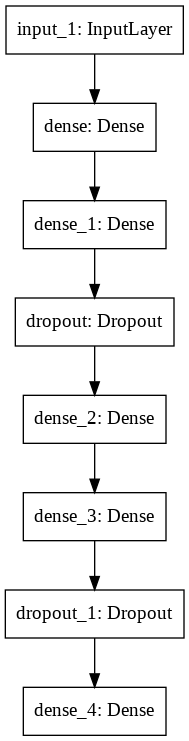

In [15]:
import tensorflow
tensorflow.keras.utils.plot_model(MLP_Model, show_layer_names=True)

In [17]:
import tensorflow.keras.backend as K
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MLP_Model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=[f1_metric])  

In [18]:
MLP_Model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs = 20, batch_size=2000, steps_per_epoch=(6779728/2000))

Epoch 1/20
3390/3389 [==============================] - 16s 5ms/step - loss: 0.2593 - f1_metric: 0.2320 - val_loss: 0.2521 - val_f1_metric: 0.2596
Epoch 2/20
3390/3389 [==============================] - 15s 4ms/step - loss: 0.2536 - f1_metric: 0.2388 - val_loss: 0.2514 - val_f1_metric: 0.1932
Epoch 3/20
3390/3389 [==============================] - 15s 4ms/step - loss: 0.2524 - f1_metric: 0.2376 - val_loss: 0.2526 - val_f1_metric: 0.1688
Epoch 4/20
3390/3389 [==============================] - 15s 5ms/step - loss: 0.2520 - f1_metric: 0.2380 - val_loss: 0.2540 - val_f1_metric: 0.1344
Epoch 5/20
3390/3389 [==============================] - 15s 4ms/step - loss: 0.2518 - f1_metric: 0.2382 - val_loss: 0.2542 - val_f1_metric: 0.0856
Epoch 6/20
3390/3389 [==============================] - 15s 4ms/step - loss: 0.2516 - f1_metric: 0.2389 - val_loss: 0.2537 - val_f1_metric: 0.1066
Epoch 7/20
3390/3389 [==============================] - 16s 5ms/step - loss: 0.2515 - f1_metric: 0.2392 - val_loss: 0.

<h2>Feature Importance</h2>

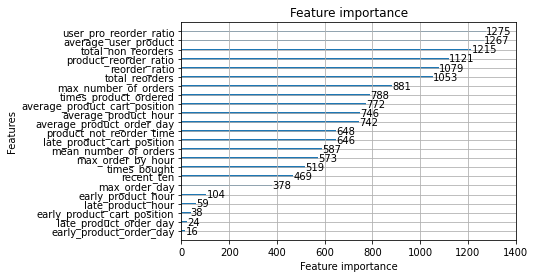

In [ ]:
lgb.plot_importance(lgb_tuned)

**Observation**

1. Although every model has almost similar results on both train and validation.

2. But still Light GBM has bit better results. 

3. Will create final prediction data with Light GBM

<h2>Function To Predict On Test Data </h2>

In [19]:
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.fillna(X.mean(), inplace=True)

final_test = normalize(test_data)

In [26]:
# This function performs prediction on test data by taking the model, test data and dataframe as input

def predict_final(data_point, model):
  new_data = data_point.copy()
  if (model==MLP_Model):
      new_data['prediction'] = (model.predict(data_point)).astype('int')
      new_data = new_data.reset_index()  
  else:
      new_data['prediction'] = (model.predict_proba(data_point)[:, 1] >= 0.21).astype('int')
      new_data = new_data.reset_index()

  final_test_data = new_data[['product_id', 'user_id', 'prediction']]

  # We are getting the user_id and order_id which belongs to "Test Set"
  orders = pd.read_csv('/content/drive/My Drive/Instacart Analysis/orders.csv')
  test_from_order = orders.loc[orders['eval_set']=='test',['user_id','order_id']]

  # Calling the predict function by passing the test data and model by which prediction is to be done
  # Merging the whole data with real test data using user_id which gives us 75000 test points

  
  predicted_results = pd.merge(final_test_data, test_from_order, how='left', on='user_id')
  predicted_results = predicted_results.drop('user_id',axis=1)
  print(predicted_results.isnull().any().sum())

  return predicted_results

<h2>Creating the submission file with the final dataframe</h2>

In [24]:
# This function takes the final dataframe and creates the submission file

def create_submission_file(final_df):
    user_product = dict()

    for row in tqdm(final_df.itertuples()):
        if row.prediction== 1:
            try:
                user_product[row.order_id] += ' ' + str(row.product_id)
            except:
                user_product[row.order_id] = str(row.product_id)

    for order in final_df.order_id:
        if order not in user_product:
            user_product[order] = 'None'

    sub = pd.DataFrame.from_dict(user_product, orient='index')
    #Reset index
    sub.reset_index(inplace=True)
    #Set column names
    sub.columns = ['order_id', 'products']
    
    return sub

def final_predict_function(final_df):
    user_product = dict()

    for row in tqdm(final_df.itertuples()):
        if row.prediction== 1:
            try:
                user_product[row.order_id] += ' ' + str(row.product_id)
            except:
                user_product[row.order_id] = str(row.product_id)

    for order in final_df.order_id:
        if order not in user_product:
            user_product[order] = 'None'    
    return user_product            

<h2>Prediction & Submission File By Each Model</h2>

<h3>1. Logistic Regression</h3>

In [ ]:
lr_predicted_df = predict_final(final_test, lr)
lr_submission_file = create_submission_file(lr_predicted_df)
lr_submission_file.to_csv('/content/drive/My Drive/Submission Files/logistic_regression_submission.csv',index=False, header=True)

71252it [00:00, 712517.28it/s]

0


4833292it [00:06, 772587.92it/s]


In [ ]:
print("F1 Score on Test Data From Kaggle 0.359470")

F1 Score on Test Data From Kaggle 0.359470


<h3>2. Decision Tree</h3>

In [ ]:
dtree_predicted_df = predict_final(final_test, dtree_tuned)
dtree_submission_file = create_submission_file(dtree_predicted_df)

dtree_submission_file.to_csv('/content/drive/My Drive/Submission Files/Decision_Tree_Submission.csv', index=False, header=True)

70391it [00:00, 703907.31it/s]

0


4833292it [00:06, 743968.04it/s]


In [ ]:
print("F1 Score on Test Data From Kaggle 0.366460")

F1 Score on Test Data From Kaggle 0.366460


<h3>3. Random Forest</h3>

In [ ]:
random_forest_predicted_df = predict_final(final_test, rf_tuned)
random_forest_submission_file = create_submission_file(random_forest_predicted_df)

random_forest_submission_file.to_csv('/content/drive/My Drive/Submission Files/random_forest_submission.csv', index=False, header=True)

88649it [00:00, 886484.50it/s]

0


4833292it [00:05, 953017.29it/s]


In [ ]:
print("F1 Score on Test Data From Kaggle 0.366450")

F1 Score on Test Data From Kaggle 0.366450


<h3>4. Light GBM</h3>

In [ ]:
lgb_predicted_df = predict_final(final_test, lgb_tuned)
lgb_submission_file = create_submission_file(lgb_predicted_df)

lgb_submission_file.to_csv('/content/drive/My Drive/Submission Files/light_gbm_submission.csv', index=False, header=True)

In [ ]:
print("F1 Score on Test Data From Kaggle 0.363680")

F1 Score on Test Data From Kaggle 0.363680


<h3>5. Stacked Model</h3>

In [ ]:
stacked_predicted_df = predict_final(final_test, stack_classifier)
stacked_submission_file = create_submission_file(stacked_predicted_df)

stacked_submission_file.to_csv('/content/drive/My Drive/Submission Files/stacked_submission.csv', index=False, header=True)    

74658it [00:00, 746573.59it/s]

0


4833292it [00:05, 877524.22it/s]


In [30]:
print("F1 Score on Test Data From Kaggle 0.255930")

F1 Score on Test Data From Kaggle 0.255930


<h3>6. Meta Classifier</h3>

In [ ]:
meta_final_df = final_test.copy()
test_prediction_df = prediction_test(models, meta_final_df)
test_pred = (lgb_final.predict_proba(test_prediction_df)[:, 1] >= 0.21).astype('int')
meta_final_df['prediction'] = test_pred

meta_final_df = meta_final_df.reset_index()

meta_test_data = meta_final_df[['product_id', 'user_id', 'prediction']]

# We are getting the user_id and order_id which belongs to "Test Set"
orders = pd.read_csv('/content/drive/My Drive/Instacart Analysis/orders.csv')
test_from_orders = orders.loc[orders['eval_set']=='test',['user_id','order_id']]

# Calling the predict function by passing the test data and model by which prediction is to be done
# Merging the whole data with real test data using user_id which gives us 75000 test points

  
predicted_results_meta = pd.merge(meta_test_data, test_from_orders, how='left', on='user_id')
predicted_results_meta = predicted_results_meta.drop('user_id',axis=1)
print(predicted_results_meta.isnull().any().sum())

0


In [ ]:
meta_classifier_submission_file = create_submission_file(predicted_results_meta)
meta_classifier_submission_file.to_csv('/content/drive/My Drive/Submission Files/meta_classifier_submission.csv',index=False, header=True)

4833292it [00:05, 907184.79it/s]


In [ ]:
print("F1 Score on Test Data From Kaggle 0.280000")

F1 Score on Test Data From Kaggle 0.280000


<h3>7. Multi Layer Perceptron </h3>

In [29]:
mlp_predicted_df = predict_final(final_test, MLP_Model)
mlp_submission_file = create_submission_file(mlp_predicted_df)

mlp_submission_file.to_csv('/content/drive/My Drive/Submission Files/mlp_submission.csv', index=False, header=True)    

82643it [00:00, 826395.32it/s]

0


4833292it [00:04, 1112900.61it/s]


In [ ]:
print("F1 Score on Test Data From Kaggle 0.255930")

<h1>Comparing Results Of Each Model</h1>

In [31]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Train F1 Score", "Validation F1 Score", "Kaggle Test F1 Score"]
table.add_row(["Logistic Regression", 0.414431, 0.415396, 0.359470])
table.add_row(["Decision Tree", 0.425405, 0.423107, 0.366460])           
table.add_row(["Random Forest", 0.425082, 0.422441, 0.366450])
table.add_row(["Light GBM", 0.432666, 0.428093, 0.363680])
table.add_row(["Stacked Model",  0.298419, 0.294584, 0.255930])
table.add_row(["Meta Classifier",  0.294019, 0.295305, 0.28001])
table.add_row(["Multi Level Perceptron",  0.241301, 0.081301, 0.063320])

print(table) 

+------------------------+----------------+---------------------+----------------------+
|         Model          | Train F1 Score | Validation F1 Score | Kaggle Test F1 Score |
+------------------------+----------------+---------------------+----------------------+
|  Logistic Regression   |    0.414431    |       0.415396      |       0.35947        |
|     Decision Tree      |    0.425405    |       0.423107      |       0.36646        |
|     Random Forest      |    0.425082    |       0.422441      |       0.36645        |
|       Light GBM        |    0.432666    |       0.428093      |       0.36368        |
|     Stacked Model      |    0.298419    |       0.294584      |       0.25593        |
|    Meta Classifier     |    0.294019    |       0.295305      |       0.28001        |
| Multi Level Perceptron |    0.241301    |       0.081301      |       0.06332        |
+------------------------+----------------+---------------------+----------------------+


<h1> Observation</h1>

Decision Tree is the best model with Test F1-Score of 0.36646

So will use product dataframe generated by decision tree

<h1>Final Predict Function</h1>

1. Here our task is to predict the products which are going to be reordered withn in a certain order id.

2. So for final predict function it can never expect any new order-id or a new user. As if the order-id or user is new there is no chance of any product being reordered when products are never ordered before.

3. This can be seen as cold-start problem.

4. So for my final predict function I followed below approach.
I took all the prediction from train, validation and test so when a order-id comes and we already have that order-id the function returns list of all the products which can be reordered.

5. Still, there was a issue in above approach as I tried to concat train, validaton, test prediction and build a dictionary consisting of order id and product id. But the problem was it was not possible to do so. As it was taking huge amount of time even after I left it to run overnight session got crashed/disconnected itself. So can't use the same approach.

6. Time taken last night was
13094627it [9:57:59, 127.73it/s]

7. So alternative of that I have just taken the test data and predict function work on top of that.

8. Since that approach was not working I removed that code to make notebook look more clean.

<h1>Function For Prediction</h1>

In [ ]:
user_product = final_predict_function(dtree_predicted_df)

def pred(order_id, prediction_dict = user_product):    
    product_list = user_product.get(order_id,"The order id does not exist! The user is new so no point of product being reordered")
    return product_list


4833292it [00:05, 867771.11it/s]


In [ ]:
products = pd.read_csv('/content/drive/My Drive/Instacart Analysis/products.csv')

In [ ]:
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [ ]:
test_point_success = pred(2897111)
test_point_fail = pred(2897)

product_name = list()
for i in test_point_success.split(" "):
    product_name.append(i)

product_list = products[products['product_id'].isin(product_name)]['product_name']

print("Valid Case")
print('Products to be re-ordered are: ')
print(product_list)
print("_"*80)
print("Invalid Case", test_point_fail)

Valid Case
Products to be re-ordered are: 
2304                                Baby Persian Cucumbers
3799                     Hampshire 100% Natural Sour Cream
5449                                    Small Hass Avocado
5817                                           White Onion
13965                                      Chicken Pot Pie
17007                        Shredded Sharp Cheddar Cheese
17680                           Puffed Wheat Cereal Cereal
21136                                 Organic Strawberries
24851                                               Banana
30134                               Cheddar Cheese Burrito
30226              Bag of Dutch Yellow Fingerling Potatoes
31267                                        Sandwich Bags
35913                      Dha Omega 3 Reduced Fat 2% Milk
38562                        Mint Chocolate Chip Ice Cream
40909                                            Root Beer
44565                                      Thick Cut Bacon
49415    Orga